With object oriented programming done:

# First example - Tracer breakthrough

In this lesson, we will:
- Create and connect our first systems of unit operations.
- Run CADET and analyze the results.

## Example 1: Our target flow sheet.

In a first example, we will look at a simple system with just three unit operations: an [Inlet](https://cadet-process.readthedocs.io/en/latest/reference/generated/CADETProcess.processModel.Inlet.html), a Column (modeled as an [LRM](https://cadet-process.readthedocs.io/en/latest/reference/generated/CADETProcess.processModel.LumpedRateModelWithoutPores.html)), and an [Outlet](https://cadet-process.readthedocs.io/en/latest/reference/generated/CADETProcess.processModel.Outlet.html).

```{figure} ./resources/flow_sheet_PFR.png
:width: 60%
```

We will load the column with a non-binding tracer molecule (such as e.g. Dextran or Micromer particles) and inspect the shape and timing of the breakthrough curve.

## 1. Setting up the model

The common denominator of everything we model (unit operations, flows, events, etc.) are the components that we model. So let us first create a `ComponentSystem` to manage and keep track of our components.

#### Component System

- `ComponentSystem` ensure that all parts of the process have the same number of components.
- Components can be named which automatically adds legends to the plot methods.

For advanced use, see [here](https://cadet-process.readthedocs.io/en/latest/reference/process_model/component_system.html).

In [62]:
from CADETProcess.processModel import ComponentSystem

component_system = ComponentSystem(1)

## Unit Operations

For an overview of all models in CADET-Process, see [here](https://cadet-process.readthedocs.io/en/latest/reference/process_model/unit_operation_models.html).

Unit operations require:
- the `ComponentSystem`
- as a unique name.

Note that the name string passed in the constructor is later used to reference the unit in the flow sheet for setting `Events` and `OptimizationVariables`.

## Inlet

In CADET, the `Inlet` pseudo unit operation serves as source for the system and is used to create arbitary concentration profiles as boundary conditions (see also [here](https://cadet-process.readthedocs.io/en/latest/reference/generated/CADETProcess.processModel.Inlet.html)).

- Concentration profiles are described using a third degree piecewise polynomial for each component.
- Flow rate can be expressed as a third degree piecewise polynomial.

Here, the flow rate is constant, we can directly set the parameter on the object.

Note that we have to convert all units to SI units.


```{note}
Generally, CADET can be used with any consistent system of units.
However, we strongly recommend converting everything to the SI system.
```

In [63]:
from CADETProcess.processModel import Inlet

inlet = Inlet(component_system, "inlet")
inlet.c = 1  # mol / m^3
inlet.flow_rate = 1e-7 
inlet.parameters

{'c': array([[1., 0., 0., 0.]]),
 'flow_rate': array([1.e-07, 0.e+00, 0.e+00, 0.e+00])}

Note that every unit operation model has different model parameters.
To display all parameters, simply print the `parameters` attribute.

## Outlet
The `Outlet` is another pseudo unit operation that serves as sink for the system (see also [here](https://cadet.github.io/master/modelling/unit_operations/outlet)).

In [64]:
from CADETProcess.processModel import Outlet
outlet = Outlet(component_system, "outlet")
outlet.parameters

{}

Note that the `Outlet` unit does not have any model parameters.

## Column: Lumped Rate Model without Pores

In this example, we will use the `LumpedRateModelWithoutPores`. For the model equations see [here](https://cadet.github.io/master/modelling/unit_operations/lumped_rate_model_without_pores.html) and the parameters [here](https://cadet.github.io/master/interface/unit_operations/lumped_rate_model_without_pores.html).

Assume the following parameters:


| Parameter        | Value | Unit          |
| ---------------- | ----- | ------------- |
| Length           | 0.1   | $m$           |
| Diameter         | 0.2   | $m$           |
| Porosity         | 0.4   | -             |
| Axial Dispersion | 1e-7  | $m^2 s^{-1}$  |

In [65]:
from CADETProcess.processModel import LumpedRateModelWithoutPores

column = LumpedRateModelWithoutPores(component_system, "column")
column.required_parameters
column.total_porosity = 0.4
column.diameter = 0.2
column.length = 0.1
column.axial_dispersion = 1e-7

## Flow Sheet Connectivity

```{figure} ./resources/flow_sheet_PFR.png
:width: 60%
```

The `FlowSheet` stores the connectivity between different unit operations.

For more information, see also [here](https://cadet-process.readthedocs.io/en/latest/reference/process_model/flow_sheet.html).

In [66]:
from CADETProcess.processModel import FlowSheet

flow_sheet = FlowSheet(component_system, "flow_sheet")

flow_sheet.add_unit(inlet)
flow_sheet.add_unit(outlet)
flow_sheet.add_unit(column)

flow_sheet.add_connection(inlet, column)
flow_sheet.add_connection(column, outlet)

## The Process

The Process class handles all time-dependent configurations. In this case, we just need to set the simulation time to 2000 seconds.

In [67]:
from CADETProcess.processModel import Process
process = Process(flow_sheet, "process")
process.cycle_time = 20000

## 3. Setting up the simulator and running the simulation

To simulate the process, a process simulator needs to be configured.
If no path is specified, CADET-Process will try to autodetect CADET.

In [68]:
from CADETProcess.simulator import Cadet

simulator = Cadet()
# simulator = Cadet("/opt/conda/envs/CADET/bin/cadet-cli")

If a specific version of CADET is to be used, add the install path to the constructor:

```
process_simulator = Cadet(install_path='/path/to/cadet/executable')
```

To check that everything works correctly, you can call the check_cadet method:

In [69]:
simulator.check_cadet()

Test simulation completed successfully


True

Now, run the simulation:

In [70]:
simulation_results = simulator.simulate(process)

(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='$time~/~min$', ylabel='$c~/~mM$'>)

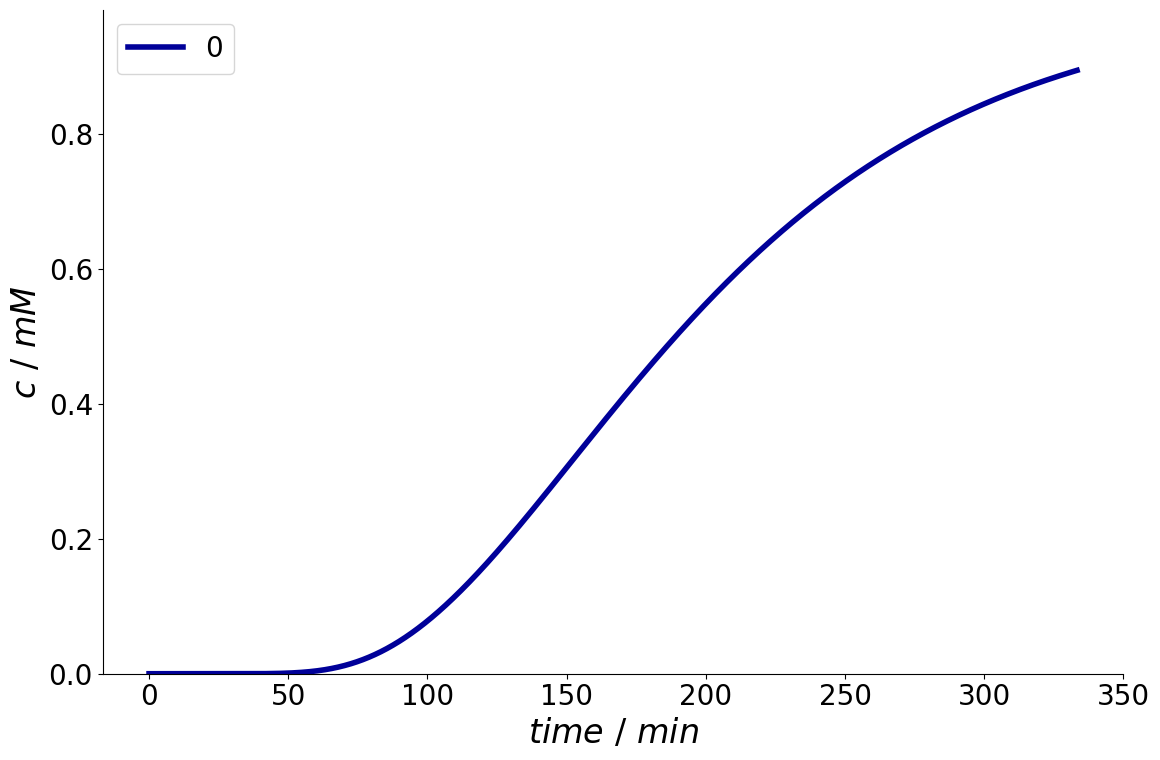

In [71]:
simulation_results.solution.outlet.outlet.plot()

## 4. Plotting the results

The simulation_results object contains the solution for the inlet and outlet of every unit operation also provide plot methods.

## Visualization

Additionally to the solution at the inlet and outlet of a unit operation, we can also take a look inside the column to see the peak move.

For this purpose, set the flag in the unit's `SolutionRecorder`.
Then, the `SimulationResults` will also contain an entry for the bulk.

**Note:** Since this solution is two-dimensinal (space and time), the solution can be plotted at a given position (`plot_at_location`) or a given time (`plot_at_time`).

In [72]:
column.solution_recorder.write_solution_bulk = True
simulation_results = simulator.simulate(process)
simulation_results.solution.column.bulk.solution.shape

(20001, 100, 1)

In [89]:
dictionary = {
    "some_key": 1,
    "another_key": 4,
    4: 5,
    "nested_key": {
        "sub_key": 4
    }
}

In [93]:
dictionary.values()

dict_values([1, 4, 5, {'sub_key': 4}])

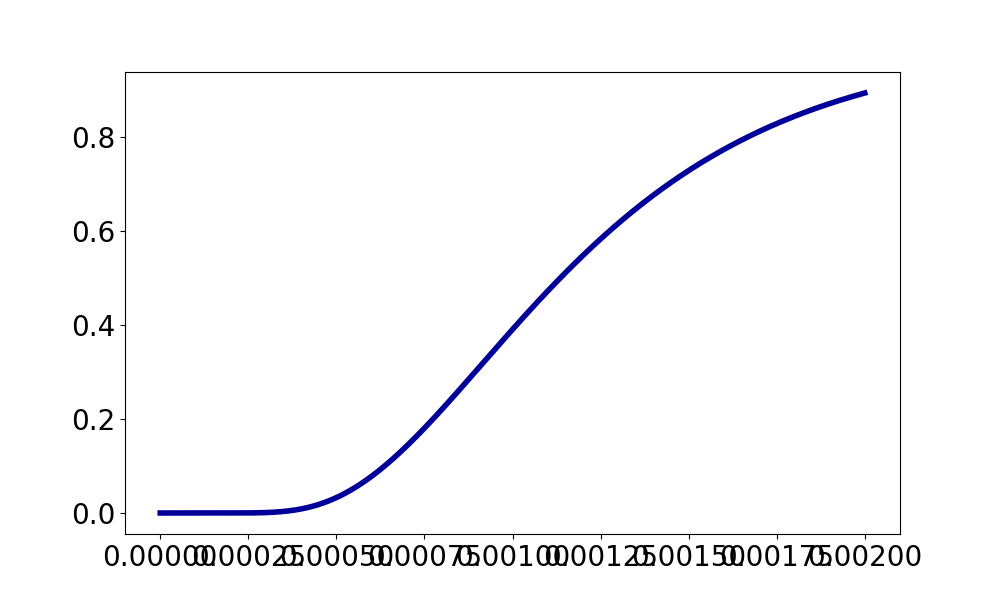

In [86]:
outlet = simulation_results.solution.column.outlet.solution#
time = simulation_results.time_complete
volume = time * inlet.flow_rate[0]

import matplotlib.pyplot as plt

plt.figure()
plt.plot(volume, outlet)


interactive(children=(IntSlider(value=0, description='Time', layout=Layout(width='800px'), max=20000, step=10,…

<function __main__.graph_column(time=0)>

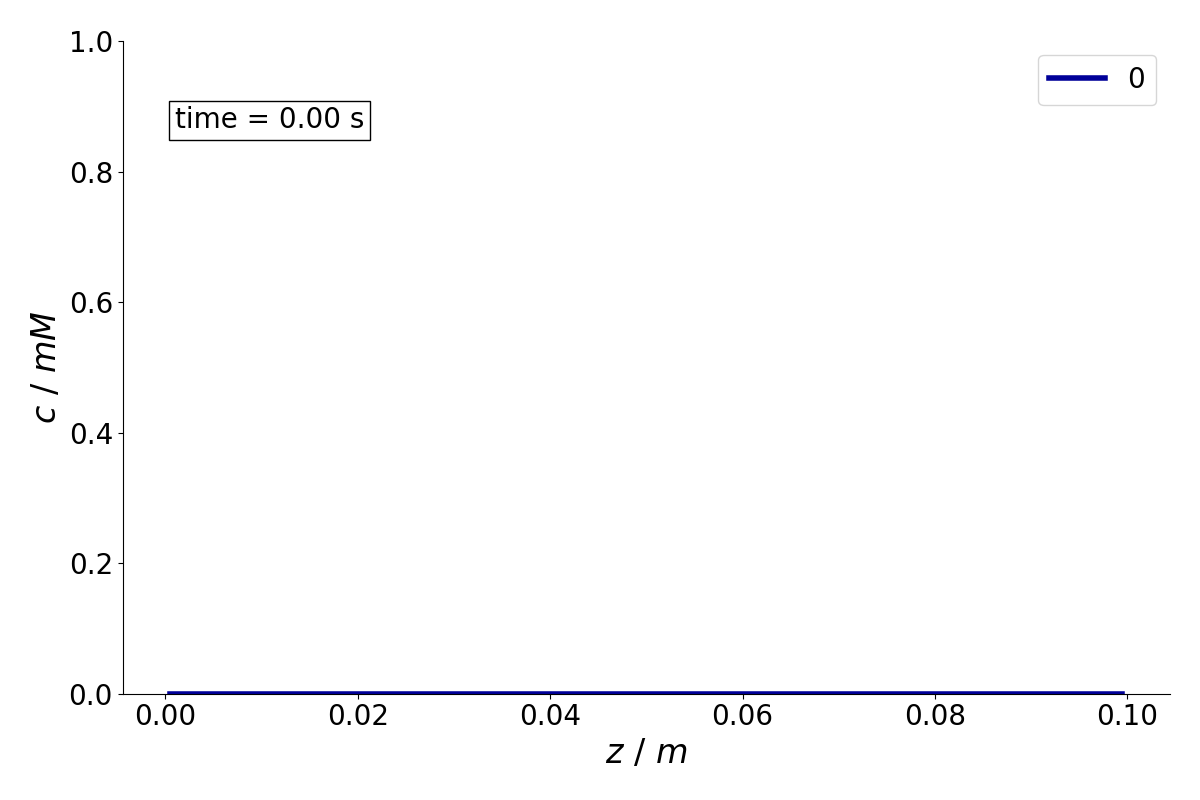

In [77]:
%matplotlib ipympl
from ipywidgets import interact, interactive
import ipywidgets as widgets
import matplotlib.pyplot as plt

fig, ax = simulation_results.solution.column.bulk.plot_at_time(0)
ax.set_ylim(0, 1)
plt.tight_layout()

# Visualization
def graph_column(time=0):
    ax.clear()
    simulation_results.solution.column.bulk.plot_at_time(time, ax=ax)
    ax.set_ylim(0, 1)

style = {'description_width': 'initial'}
interact(
    graph_column,
    time=widgets.IntSlider(
        min=0, max=process.cycle_time, step=10, layout={'width': '800px'}, style=style, description='Time'
    )
)